In [1]:
!wget -O train_authors.csv https://raw.githubusercontent.com/MSUcourses/Data-Analysis-with-Python/main/Deep%20Learning/Files/train_authors_new.csv

--2024-12-01 14:00:23--  https://raw.githubusercontent.com/MSUcourses/Data-Analysis-with-Python/main/Deep%20Learning/Files/train_authors_new.csv
Распознаётся raw.githubusercontent.com (raw.githubusercontent.com)… 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Подключение к raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 5163531 (4,9M) [text/plain]
Сохранение в: «train_authors.csv»

train_authors.csv   100%[===================>]   4,92M  14,0MB/s    за 0,4s    

2024-12-01 14:00:24 (14,0 MB/s) - «train_authors.csv» сохранён [5163531/5163531]



In [37]:
! pip3 install ipywidgets 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 653.1 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.4/214.4 kB 2.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 1.7 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
!wget -O test_authors.csv https://raw.githubusercontent.com/MSUcourses/Data-Analysis-with-Python/main/Deep%20Learning/Files/test_authors_new.csv

--2024-12-01 14:00:38--  https://raw.githubusercontent.com/MSUcourses/Data-Analysis-with-Python/main/Deep%20Learning/Files/test_authors_new.csv
Распознаётся raw.githubusercontent.com (raw.githubusercontent.com)… 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Подключение к raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 961703 (939K) [text/plain]
Сохранение в: «test_authors.csv»

test_authors.csv    100%[===================>] 939,16K  4,37MB/s    за 0,2s    

2024-12-01 14:00:38 (4,37 MB/s) - «test_authors.csv» сохранён [961703/961703]



In [109]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import nltk
from tqdm import tqdm_notebook
import torch.nn as nn                                                             # тут все блоки нейронных сетей, слои
import torch.nn.functional as F

from collections import Counter
from typing import List
import string

import seaborn
seaborn.set(palette='summer')

# скачиваем нужный пакет данных для работы библиотеки nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/glebslivin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [110]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [111]:
# Загрузим датасет
import pandas as pd

train_data = pd.read_csv('train_authors.csv')

train_data, val_data = train_test_split(train_data, test_size=0.5, random_state=42)

In [112]:
val_data

,text,author
522,Юлия Шигарова\nВ департаменте… но лучше не наз...,Gogol
135,"Чуб долго еще ворчал и бранился, а между тем в...",Gogol
727,Зябким мартовским днем бритоголового послушник...,Pratchett
1405,"Начнем с того, чтó у Петра получилось.\nОн сущ...",Akunin
1472,"Представьте себе существо размером с белку, бе...",Bulychev
...,...,...
311,Но материал-то остался. И довольно любопытный....,Akunin
1170,"-Эй! Парень!\nТот обернулся, и Хогэн бросил ем...",King
1175,"-Ну как знаете,- сказал я и сделал вид, будто ...",Remark
665,"-Я тебе говорю, сволочь!- сказал полицейский.-...",Remark


In [113]:
test_data = pd.read_csv('test_authors.csv')
test_data.head()

,text
0,-Не выглядывал еще. Дрыхнет… Почему да почему?...
1,"Идти ему было немного; он даже знал, сколько ш..."
2,Придется вернуться в самое изголовье и начать ...
3,"-С ума сойти,- сказал отец. Он обернулся, увид..."
4,"Во-вторых, положение Петра после захвата власт..."


In [114]:
writers = ['Akunin', 'Bulychev', 'Chehov', 'Dostoevsky', 'Gogol', 'King',
       'Pratchett', 'Remark']
writers_to_label = {writer: i for i, writer in enumerate(writers)}
label_to_writers = {i: writer for i, writer in enumerate(writers)}

In [115]:
dataset = {}

dataset['train'] = [{'text':text, 'author':writers_to_label[label]} \
              for text, label in zip(np.array(train_data['text']), np.array(train_data['author']))]
dataset['val'] = [{'text':text, 'author':writers_to_label[label]} \
              for text, label in zip(np.array(val_data['text']), np.array(val_data['author']))]
dataset['test'] = [{'text':text, 'author': 0} \
              for text in np.array(test_data['text'])]

In [116]:
# библиотека для работы со строками. С ее помощью мы удалим знаки препинания
import string
# счетчик для создания счетчика слов
from collections import Counter
# библиотека, с помощью которой разобьем текст на токены
import nltk
from nltk.tokenize import word_tokenize

nltk.download('punkt_tab')

# скачиваем нужный пакет данных для работы библиотеки nltk
nltk.download('punkt')

# функция для обработки предложения
def process_and_tokenize_text(text):
    # приводим к нижнему регистру и убираем пунктуацию
    prccessed_text = text.lower().translate(
        str.maketrans('', '', string.punctuation))
    # токенизируем текст
    tokens = word_tokenize(prccessed_text)
    return tokens

# массивы для хранения токенизированных тренировочных и тестовых данных
train_data = []
val_data = []
test_data = []

# пустой счетчик слов
words = Counter()

# проходимся по текстам обучающего датасета и предобрабатываем их
for example in tqdm_notebook(dataset['train']):
    text = example['text']
    label = example['author']
    text_processed = process_and_tokenize_text(text)
    train_data.append((text_processed, label))

    # увеличиваем счетчик каждого слова в словаре
    for word in text_processed:
        words[word] += 1

for example in tqdm_notebook(dataset['val']):
    text = example['text']
    label = example['author']
    text_processed = process_and_tokenize_text(text)
    val_data.append((text_processed, label))

    # увеличиваем счетчик каждого слова в словаре
    for word in text_processed:
        words[word] += 1
#проходимся по текстам тестового датасета и предобрабатываем их
for example in tqdm_notebook(dataset['test']):
    text = example['text']
    label = example['author']
    text_processed = process_and_tokenize_text(text)
    test_data.append((text_processed, label))

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/glebslivin/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/glebslivin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/var/folders/q8/b2ly0p957ml1pzxty4q0cbyc0000gn/T/ipykernel_3710/2050094917.py:32: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for example in tqdm_notebook(dataset['train']):


  0%|          | 0/867 [00:00<?, ?it/s]

/var/folders/q8/b2ly0p957ml1pzxty4q0cbyc0000gn/T/ipykernel_3710/2050094917.py:42: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for example in tqdm_notebook(dataset['val']):


  0%|          | 0/867 [00:00<?, ?it/s]

/var/folders/q8/b2ly0p957ml1pzxty4q0cbyc0000gn/T/ipykernel_3710/2050094917.py:52: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for example in tqdm_notebook(dataset['test']):


  0%|          | 0/330 [00:00<?, ?it/s]

In [146]:
# создаем словарь как множество слов
vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
# будем добавлять в словарь только те слова, которые
# встречались в обучающих данных не менее 25 раз
    
counter_threshold = 15

# пополняем словарь словами из words
for char, cnt in words.items():
    if cnt > counter_threshold:
        vocab.add(char)
len(vocab)

2707

In [147]:
word2ind = {token: i for i, token in enumerate(vocab)}
ind2word = {i: token for token, i in word2ind.items()}

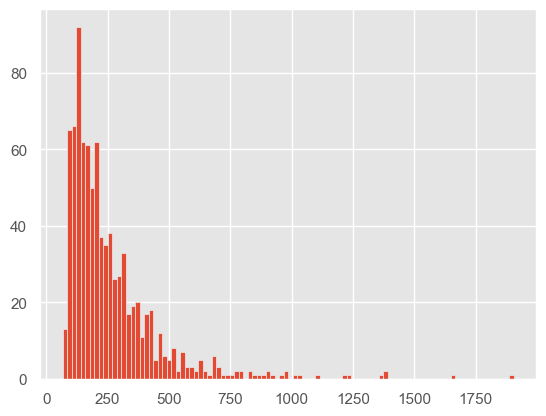

In [148]:
plt.hist([len(x[0]) for x in train_data], bins=100);

In [149]:
def collate_fn_with_padding(input_batch, max_len=256):
    # input_batch — батч пар (токенизированный текст, label)
    texts = [x[0] for x in input_batch]
    labels = [x[1] for x in input_batch]
    # для каждого элемента батча получаем длину токенизированного текста в токенах
    seq_lens = [len(x) for x in texts]
    # определяем максимальную длину элементов в текущем батче
    max_seq_len = min(max(seq_lens), max_len)

    # проходимся по элементам батча и заменяем токены на их индексы из словаря
    # также последовательности короче max_seq_len дополняем токенами <pad>
    processed_texts = []
    for text, label in zip(texts, labels):
        text = text[:max_seq_len]
        text = [word2ind[x] if x in vocab else word2ind['<unk>'] for x in text]
        for _ in range(max_seq_len - len(text)):
            text.append(word2ind['<pad>'])

        processed_texts.append(text)

    # переводим элементы батча в форматы тензоров
    processed_texts = torch.LongTensor(processed_texts).to(device)
    labels = torch.LongTensor(labels).to(device)

    # собираем батч
    processed_batch = {
        'input_ids': processed_texts,
        'label': labels
    }

    return processed_batch

In [150]:
# поделим тестовые данные на val и test



# заводим даталоадеры
batch_size = 128
train_dataloader = DataLoader(
    train_data, shuffle=True, collate_fn=collate_fn_with_padding, batch_size=batch_size)

val_dataloader = DataLoader(
    val_data, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)

test_dataloader = DataLoader(
    test_data, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)

In [151]:
val_data[1]

(['чуб',
  'долго',
  'еще',
  'ворчал',
  'и',
  'бранился',
  'а',
  'между',
  'тем',
  'в',
  'то',
  'же',
  'время',
  'раздумывал',
  'на',
  'что',
  'бы',
  'решиться',
  'ему',
  'до',
  'смерти',
  'хотелось',
  'покалякать',
  'о',
  'всяком',
  'вздоре',
  'у',
  'дьяка',
  'где',
  'без',
  'всякого',
  'сомнения',
  'сидел',
  'уже',
  'и',
  'голова',
  'и',
  'приезжий',
  'бас',
  'и',
  'дегтярь',
  'микита',
  'ездивший',
  'через',
  'каждые',
  'две',
  'недели',
  'в',
  'полтаву',
  'на',
  'торги',
  'и',
  'отпускавший',
  'такие',
  'шутки',
  'что',
  'все',
  'миряне',
  'брались',
  'за',
  'животы',
  'со',
  'смеху',
  'уже',
  'видел',
  'чуб',
  'мысленно',
  'стоявшую',
  'на',
  'столе',
  'варенуху',
  'все',
  'это',
  'было',
  'заманчиво',
  'правда',
  'но',
  'темнота',
  'ночи',
  'напомнила',
  'ему',
  'о',
  'той',
  'лени',
  'которая',
  'так',
  'мила',
  'всем',
  'козакам',
  'как',
  'бы',
  'хорошо',
  'теперь',
  'лежать',
  'поджав

In [152]:
class SimpleRNN(nn.Module):
    def __init__(self, hidden_dim, vocab_size, num_classes,
        aggregation_type: str = 'last'):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        
        self.rnn =  nn.GRU(hidden_dim,hidden_dim, batch_first = True, num_layers= 3, dropout=0.2)
        
        self.layer_norm = nn.LayerNorm(hidden_dim)
        
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

        self.dropout = nn.Dropout(p=0.2)

        self.aggregation_type = aggregation_type
    def forward(self, input_batch):
        embeddings = self.embedding(input_batch)
        output, _ = self.rnn(embeddings) 

        output = self.layer_norm(output)

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0]         #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1)           #[batch_size, hidden_dim]
        elif self.aggregation_type == 'last':
            output = output[:, -1, :]
        else:
            raise ValueError("Invalid aggregation_type")

        output = F.tanh(output)
        output = F.tanh(self.dropout(self.fc1(output)))   # [batch_size, hidden_dim]
        output = self.fc2(output)    

        return output
            



In [153]:
def evaluate(model, dataloader):
    """
    Calculate accuracy on data from dataloader.
    """

    predictions = []
    target = []
    with torch.no_grad():
        for batch in tqdm_notebook(dataloader,
                                   desc=f'Evaluating'):
            logits = model(batch['input_ids'])
            predictions.append(logits.argmax(dim=1))
            target.append(batch['label'])

    predictions = torch.cat(predictions)
    target = torch.cat(target)
    accuracy = (predictions == target).float().mean().item()

    return accuracy

In [154]:
def train(model, optimizer, criterion, num_epoch, eval_steps):

    losses = []
    accs_train = []
    accs_val = []

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()
        for i, batch in enumerate(tqdm_notebook(train_dataloader,
                                                desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model.eval()
                accs_train.append(evaluate(model, train_dataloader))
                accs_val.append(evaluate(model, val_dataloader))
                model.train()

        losses.append(sum(epoch_losses) / len(epoch_losses))

    return losses, accs_train, accs_val

In [155]:
model = SimpleRNN(hidden_dim=256,
                 vocab_size=len(vocab),
                  num_classes=8,
                  aggregation_type= 'mean'
                  ).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())
losses, accs_train, accs_val = train(model,
                                     optimizer,
                                     criterion,
                                     num_epoch=3,
                                     eval_steps=len(train_dataloader) // 2)



/var/folders/q8/b2ly0p957ml1pzxty4q0cbyc0000gn/T/ipykernel_3710/277674689.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, batch in enumerate(tqdm_notebook(train_dataloader,


Training epoch 0::   0%|          | 0/7 [00:00<?, ?it/s]

/var/folders/q8/b2ly0p957ml1pzxty4q0cbyc0000gn/T/ipykernel_3710/4154025148.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm_notebook(dataloader,


Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

In [163]:
losses, accs_train, accs_val = train(model,
                                     optimizer,
                                     criterion,
                                     num_epoch=3,
                                     eval_steps=len(train_dataloader) // 2)


/var/folders/q8/b2ly0p957ml1pzxty4q0cbyc0000gn/T/ipykernel_3710/277674689.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, batch in enumerate(tqdm_notebook(train_dataloader,


Training epoch 0::   0%|          | 0/7 [00:00<?, ?it/s]

/var/folders/q8/b2ly0p957ml1pzxty4q0cbyc0000gn/T/ipykernel_3710/4154025148.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm_notebook(dataloader,


Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

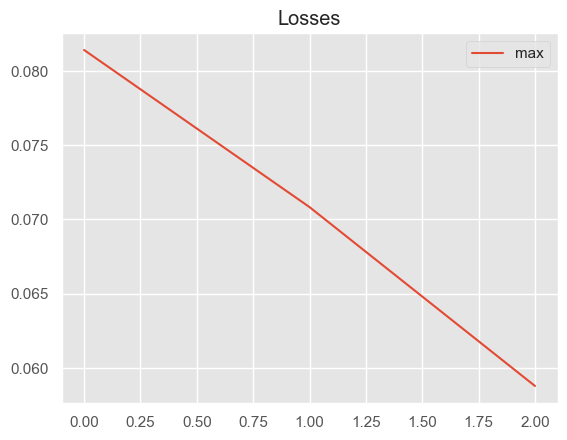

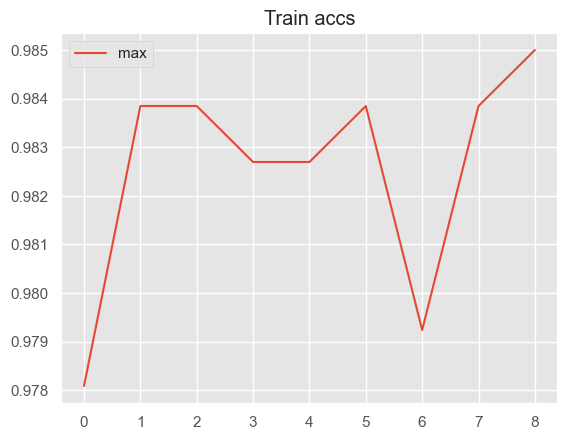

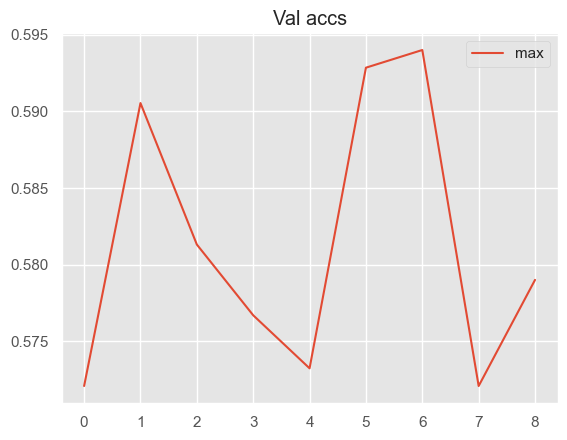

In [164]:
plt.style.use('ggplot')
plt.plot(losses)
plt.title('Losses')
plt.legend(['max', 'mean', 'last'])
plt.show()


plt.plot(accs_train)
plt.title('Train accs')
plt.legend(['max', 'mean', 'last'])
plt.show()

plt.plot(accs_val)
plt.title('Val accs')
plt.legend(['max', 'mean', 'last'])
plt.show()

In [165]:
def get_predictions(model, dataloader):
    """
    Calculate accuracy on data from dataloader.
    """

    model.eval()
    predictions = []
    with torch.no_grad():
        for batch in tqdm_notebook(dataloader,
                                   desc=f'Evaluating'):
            logits = model(batch['input_ids'])
            predictions.append(logits.argmax(dim=1))

    predictions = torch.cat(predictions).data.cpu().numpy()

    return predictions

In [18]:
for batch in val_dataloader:   
    print(batch)


KeyError: 0

In [132]:
test_data


[]

In [166]:
predictions = get_predictions(model, test_dataloader)
predictions = [label_to_writers[x] for x in predictions]
predictions

/var/folders/q8/b2ly0p957ml1pzxty4q0cbyc0000gn/T/ipykernel_3710/3324781086.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm_notebook(dataloader,


Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

['Bulychev',
 'Dostoevsky',
 'Akunin',
 'Bulychev',
 'Pratchett',
 'Pratchett',
 'Pratchett',
 'Pratchett',
 'Chehov',
 'King',
 'Akunin',
 'Akunin',
 'Chehov',
 'Gogol',
 'Bulychev',
 'Pratchett',
 'Pratchett',
 'Akunin',
 'Akunin',
 'Akunin',
 'Akunin',
 'Bulychev',
 'Akunin',
 'Akunin',
 'Akunin',
 'Bulychev',
 'Akunin',
 'King',
 'Dostoevsky',
 'King',
 'Akunin',
 'Pratchett',
 'Akunin',
 'King',
 'Pratchett',
 'Bulychev',
 'Akunin',
 'King',
 'Dostoevsky',
 'Remark',
 'King',
 'King',
 'Pratchett',
 'King',
 'Remark',
 'King',
 'Akunin',
 'Pratchett',
 'Akunin',
 'Akunin',
 'Pratchett',
 'King',
 'Pratchett',
 'Akunin',
 'Chehov',
 'Bulychev',
 'King',
 'Akunin',
 'Akunin',
 'Akunin',
 'Akunin',
 'Akunin',
 'Akunin',
 'Bulychev',
 'King',
 'Akunin',
 'Pratchett',
 'Pratchett',
 'King',
 'Akunin',
 'Akunin',
 'Chehov',
 'Dostoevsky',
 'Bulychev',
 'King',
 'Akunin',
 'Pratchett',
 'King',
 'Pratchett',
 'Remark',
 'Bulychev',
 'Akunin',
 'Akunin',
 'Akunin',
 'Gogol',
 'Bulychev',


In [167]:
np.save('submission_hw07.npy', predictions, allow_pickle=True)
print('Ответ сохранен в файл `submission_hw07.npy`')

Ответ сохранен в файл `submission_hw07.npy`


In [ ]:
num_epoch = 5
eval_steps = len(train_dataloader) // 2


losses_type = {}
accs_train_type = {}
accs_val_type = {}

for aggregation_type in ['max', 'mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []

    model = SimpleRNN(hidden_dim=256,
                      vocab_size=len(vocab),
                      num_classes=8,
                      aggregation_type=aggregation_type
                      ).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)

    losses, accs_train, accs_val = train(model,
                                         optimizer,
                                         criterion,
                                         num_epoch=3,
                                         eval_steps=len(train_dataloader) // 2)

    losses_type[aggregation_type] = losses
    accs_train_type[aggregation_type] = accs_train
    accs_val_type[aggregation_type] = accs_val

Starting training for max


/var/folders/q8/b2ly0p957ml1pzxty4q0cbyc0000gn/T/ipykernel_2779/277674689.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, batch in enumerate(tqdm_notebook(train_dataloader,


Training epoch 0::   0%|          | 0/14 [00:00<?, ?it/s]

/var/folders/q8/b2ly0p957ml1pzxty4q0cbyc0000gn/T/ipykernel_2779/4154025148.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm_notebook(dataloader,


Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/14 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/14 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Starting training for mean


Training epoch 0::   0%|          | 0/14 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/14 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/14 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Starting training for last


Training epoch 0::   0%|          | 0/14 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/14 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/14 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

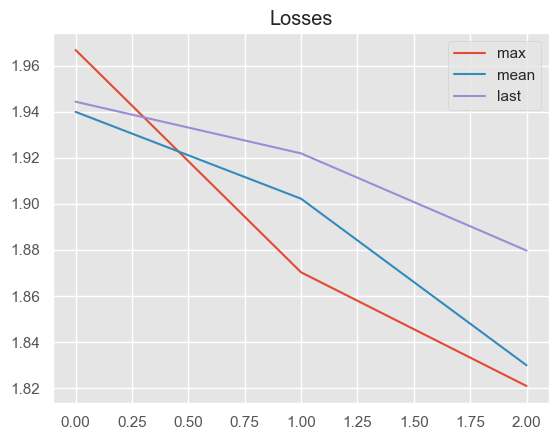

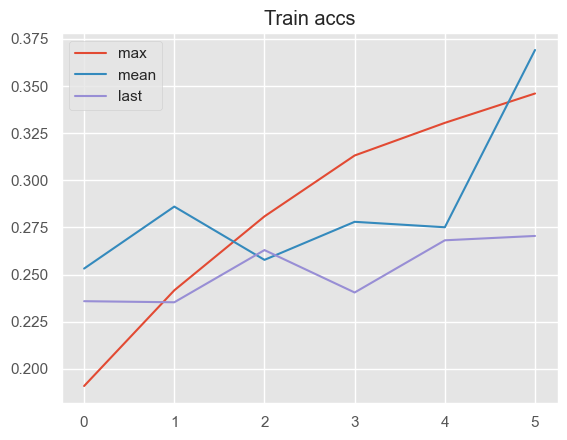

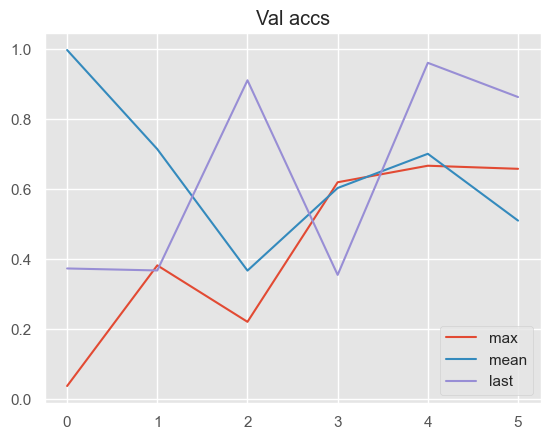

In [56]:
plt.style.use('ggplot')
for aggregation_type in ['max', 'mean', 'last']:
    plt.plot(losses_type[aggregation_type])
plt.title('Losses')
plt.legend(['max', 'mean', 'last'])
plt.show()

for aggregation_type in ['max', 'mean', 'last']:
    plt.plot(accs_train_type[aggregation_type])
plt.title('Train accs')
plt.legend(['max', 'mean', 'last'])
plt.show()

for aggregation_type in ['max', 'mean', 'last']:
    plt.plot(accs_val_type[aggregation_type])
plt.title('Val accs')
plt.legend(['max', 'mean', 'last'])
plt.show()